# **(ADD HERE THE NOTEBOOK NAME)**

## Objectives

* Using data from Kaggle, answer Business Requirement 1.


## Inputs

Following sets:

* Train

* Validation

* Test



## Outputs

Creating:
* The shapes of images
* Images per label plotted according to their variability and mean
* Plots illustrating the differences between healthy and mildewed leaves






In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspaces/project5/jupyter_notebooks'

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


In [3]:
work_dir = os.getcwd()
work_dir

'/workspaces/project5'

In [4]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns; sns.set_style("whitegrid")


In [5]:
my_data_dir = 'inputs/datasets/cherry-leaves'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'
my_data_dir

'inputs/datasets/cherry-leaves'

In [6]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
  print('There is a version is already available, please create a new version.')
  pass
else:
  os.makedirs(name=file_path)


Old version is already available, please create a new version.


# Analyzing image data and visualizing it

- calculating and plotting the average width and height of images in each label directory.

Label for the images are ['powdery_mildew', 'healthy']


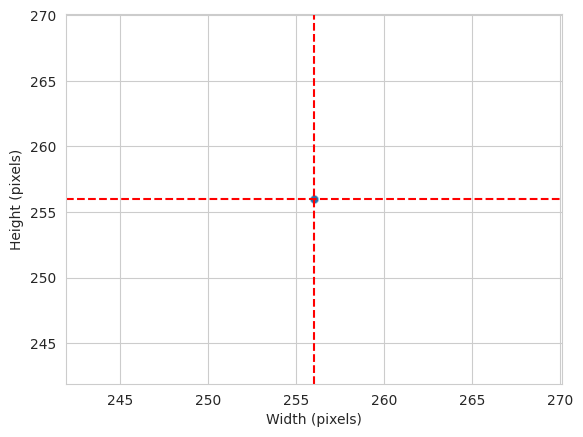

Width average: 256 
Height average: 256


In [7]:



labels = os.listdir(train_path)
print('Label for the images are',labels)

dim1, dim2 = [], []
for label in labels:
  for image_filename in os.listdir(train_path + '/'+ label):
    img = imread(train_path + '/' + label + '/'+ image_filename)
    d1, d2, colors = img.shape
    dim1.append(d1)
    dim2.append(d2)

sns.scatterplot(x=dim2, y=dim1, alpha=0.2)
plt.xlabel("Width (pixels)")
plt.ylabel("Height (pixels)")
dim1_mean = int(np.array(dim1).mean())
dim2_mean = int(np.array(dim2).mean())
plt.axvline(x=dim1_mean,color='r', linestyle='--')
plt.axhline(y=dim2_mean,color='r', linestyle='--')
plt.show()
print(f"Width average: {dim2_mean} \nHeight average: {dim1_mean}")


- save the shape of an image (64x64 with 3 channels) as a binary file using the joblib library.

In [8]:
image_shape = (64,64,3)
joblib.dump(value=image_shape ,
            filename=f"{file_path}/image_shape.pkl")

['outputs/v1/image_shape.pkl']

- Define a function called "load_image_as_array" which loads images from a directory, resizes them, and stores them in a numpy array along with their respective labels.


In [9]:
from tensorflow.keras.preprocessing import image

def load_image_as_array(my_data_dir, new_size=(50,50), n_images_per_label = 20):
  """ We generate two arrays, one with images and the other one with labels, so 
      we can analyze the processed images """
      
  X, y = np.array([], dtype='int'), np.array([], dtype='object')
  labels = os.listdir(my_data_dir)

  for label in labels:
    counter = 0
    for image_filename in os.listdir(my_data_dir + '/' + label):
      # n_images_per_label: we set a limit, since it may take too much time
      if counter < n_images_per_label:
        img = image.load_img(my_data_dir + '/' + label + '/' + image_filename, target_size=new_size)
        if image.img_to_array(img).max() > 1: 
          img_resized = image.img_to_array(img) / 255
        else: 
          img_resized = image.img_to_array(img)
        
        X = np.append(X, img_resized).reshape(-1, new_size[0], new_size[1], img_resized.shape[2])
        y = np.append(y, label)
        counter += 1

  return X, y
  
X, y = load_image_as_array(my_data_dir=train_path,
                           new_size=image_shape,
                           n_images_per_label=30)
print(X.shape, y.shape)




(60, 64, 64, 3) (60,)


- Define a function plot_mean_variability_per_labels that will take in an array of images X and their labels y, and generate plots showing the average image and variability image (standard deviation) for each unique label in the dataset, and can optionally save the resulting plots as images.

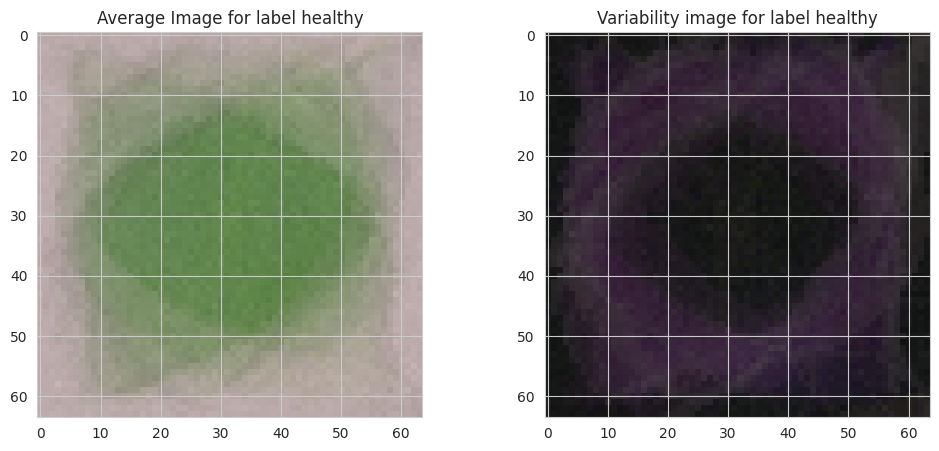

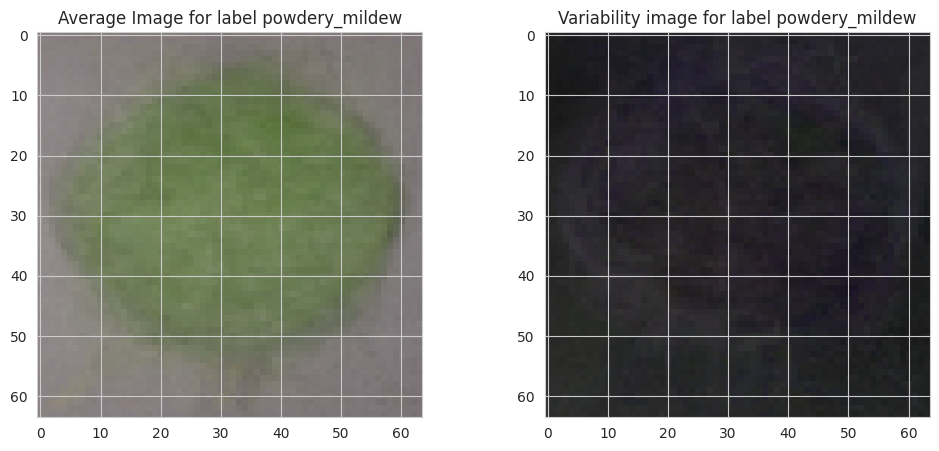

In [10]:


def plot_mean_variability_per_labels(X, y, figsize=(12,5), save_image=False):
  for label in np.unique(y):
    mask = y == label
    arr = X[mask]
    avg_img, std_img = np.mean(arr, axis=0), np.std(arr, axis=0)
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    axes[0].set_title(f"Average Image for label {label}")
    axes[0].imshow(avg_img, cmap='gray')
    axes[1].set_title(f"Variability image for label {label}")
    axes[1].imshow(std_img, cmap='gray')
    if save_image:
      plt.savefig(f"{file_path}/avg_var_{label}.png", bbox_inches='tight', dpi=150)
    else:
      plt.tight_layout()
      plt.show()

plot_mean_variability_per_labels(X, y, (12, 5), True)


- Define two functions: subset_image_label, which generates a subset of images according to a given label, and diff_bet_avg_image_labels_data_as_array, which calculates and plots the difference between the average images of two different labels. The function also saves the resulting plot if the save_image parameter is set to True.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


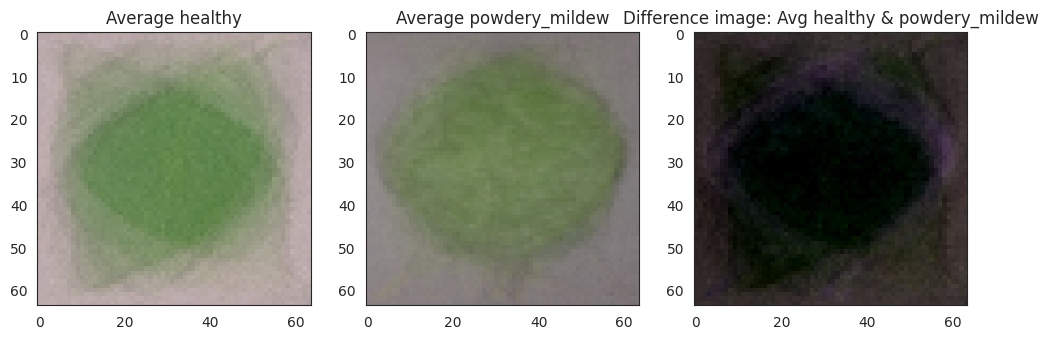

In [23]:


def subset_image_label(X,y,label_to_display):
  """ Generate a subset of images according to the label variable """
  y = y.reshape(-1,1,1)
  boolean_mask = np.any(y==label_to_display,axis=1).reshape(-1)
  return X[boolean_mask]


def diff_bet_avg_image_labels_data_as_array(X, y, label_1, label_2, figsize=(20,5), save_image=False):
  """ first generate the average image of each subset of images, and after that, calculate
      the different mean between both """
  sns.set_style("white")

  if (label_1 not in np.unique(y)) or (label_2 not in np.unique(y)):
    print(f"Either label {label} or label {label_2}, are not in {np.unique(y)} ")
    return

  # calculate mean from label1
  label1_avg = np.mean(subset_image_label(X, y, label_1), axis = 0)
  # calculate mean from label2
  label2_avg = np.mean(subset_image_label(X, y, label_2), axis = 0)

  # calculate difference and plot difference, avg label1 and avg label2
  difference_mean = label1_avg - label2_avg
  fig, axes = plt.subplots(nrows=1, ncols=3, figsize=figsize)
  axes[0].imshow(label1_avg, cmap='gray')
  axes[0].set_title(f'Average {label_1}')
  axes[1].imshow(label2_avg, cmap='gray')
  axes[1].set_title(f'Average {label_2}')
  axes[2].imshow(difference_mean, cmap='gray')
  axes[2].set_title(f'Difference image: Avg {label_1} & {label_2}')

  # Save the image
  if save_image:
    plt.savefig(f"{file_path}/avg_diff.png", bbox_inches='tight', dpi=150)
  else:
    plt.tight_layout()
    plt.show()


diff_bet_avg_image_labels_data_as_array(X=X,
                                        y=y,
                                        label_1='healthy',
                                        label_2='powdery_mildew',
                                        figsize=(12,10),
                                        save_image=True
                                        )